# FACIAL EMOTION RECOGNITION (Use FER2013 as dataset)

## 1. Import dataset and Normalize

In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FER2013Dataset(Dataset):
    """คลาส Dataset สำหรับ FER2013"""
    def __init__(self, csv_file, usage='Training', transform=None):
        self.data = pd.read_csv(csv_file)
        # กรองข้อมูลตาม 'Usage' (Training, PublicTest, PrivateTest)
        self.data = self.data[self.data['Usage'] == usage]
        self.transform = transform

        # ป้ายกำกับอารมณ์ (0-6)
        self.labels = self.data['emotion'].values

        # แปลง string ของพิกเซลให้เป็น array ของรูปภาพ
        self.images = []
        for pixels_str in self.data['pixels']:
            pixels = np.fromstring(pixels_str, dtype=int, sep=' ')
            # FER2013 เป็นภาพ 48x48
            image = pixels.reshape(48, 48).astype('uint8')
            self.images.append(image)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # แปลงเป็น PIL Image เพื่อให้ transforms ทำงานได้
        image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)

        return image, label

# --- การใช้งาน ---

# กำหนด Transforms (จำเป็นมาก!)
# 1. แปลงเป็น Grayscale (ถ้าโมเดลรับ 1 channel)
# 2. ทำ Data Augmentation (เช่น พลิกซ้ายขวา)
# 3. แปลงเป็น Tensor
# 4. Normalize ข้อมูล
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # FER2013 เป็น Grayscale
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize สำหรับ 1 channel
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# สร้าง Dataset
train_dataset = FER2013Dataset(csv_file='fer2013.csv', usage='Training', transform=train_transform)
test_dataset = FER2013Dataset(csv_file='fer2013.csv', usage='PublicTest', transform=test_transform)

# สร้าง DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ป้ายกำกับอารมณ์ (เผื่อใช้ตอนแสดงผล)
EMOTIONS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## 2. SimpleCNN with Batch Normalization

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN_with_BatchNorm(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN_with_BatchNorm, self).__init__()
        # Input: (Batch, 1, 48, 48)

        # Block 1: Conv -> BatchNorm -> ReLU -> Pool
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # <--- เพิ่ม
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # -> (Batch, 32, 24, 24)

        # Block 2: Conv -> BatchNorm -> ReLU -> Pool
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # <--- เพิ่ม
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # -> (Batch, 64, 12, 12)

        # Block 3: Conv -> BatchNorm -> ReLU -> Pool
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) # <--- เพิ่ม
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # -> (Batch, 128, 6, 6)

        # Flatten -> 128 * 6 * 6 = 4608

        # Block 4: Fully Connected
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.bn_fc1 = nn.BatchNorm1d(512) # <--- เพิ่ม (ใช้ BatchNorm1d สำหรับ FC)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes) # 7 classes

    def forward(self, x):
        # ลำดับที่นิยมคือ Conv -> BN -> ReLU
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(-1, 128 * 6 * 6)

        # ลำดับที่นิยมคือ FC -> BN -> ReLU
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x) # (ที่ Output layer สุดท้ายไม่ต้องมี ReLU/BatchNorm)

        return x

# --- การใช้งาน ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN_with_BatchNorm(num_classes=7).to(device)
print("SimpleCNN (with BatchNorm) class defined and model instance created.")
#print(model)

SimpleCNN (with BatchNorm) class defined and model instance created.


## 3. Training Loss and Validation or Evaluattion

In [7]:
import torch.optim as optim
import torch.nn as nn

# --- (สมมติว่า model, train_loader, test_loader, device อยู่ตรงนี้แล้ว) ---
model = SimpleCNN_with_BatchNorm().to(device) # (จากโค้ดก่อนหน้า)
train_loader # (จากโค้ดก่อนหน้า)
test_loader # (จากโค้ดก่อนหน้า)
device # (จากโค้ดก่อนหน้า)
# -----------------------------------------------------------------------

# กำหนด Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- ลูปการเทรน ---
num_epochs = 50

# (เผื่อเก็บ history ไว้พล็อตกราฟ)
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):

    # ==========================
    #      TRAINING LOOP
    # ==========================
    model.train() # ตั้งค่าเป็น training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # ==========================
    #     VALIDATION LOOP  <--- (ส่วนที่เพิ่มเข้ามา)
    # ==========================
    model.eval() # <--- สำคัญมาก! ตั้งค่าเป็น evaluation mode (ปิด Dropout, BatchNorm)
    val_running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad(): # <--- สำคัญมาก! ไม่ต้องคำนวณ gradient ตอนเทส
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            # Calculate accuracy
            # torch.max จะคืนค่า (max_value, max_index)
            _, predicted_labels = torch.max(outputs, 1)

            total_preds += labels.size(0)
            correct_preds += (predicted_labels == labels).sum().item()

    # คำนวณ Loss และ Accuracy ของ Validation set
    epoch_val_loss = val_running_loss / len(test_dataset)
    epoch_val_acc = (correct_preds / total_preds) * 100

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    # พิมพ์ผลลัพธ์ของ Epoch นี้
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Acc: {epoch_val_acc:.2f}%")


print("Training Finished!")

# บันทึกโมเดล
torch.save(model.state_dict(), 'fer2013_cnn_model_with_evaluate.pth') # (ผมแก้ชื่อไฟล์เล็กน้อย)
print("Model Saved!")

Epoch [1/50], Train Loss: 1.4356, Val Loss: 1.2894, Val Acc: 50.79%
Epoch [2/50], Train Loss: 1.2214, Val Loss: 1.2122, Val Acc: 54.22%
Epoch [3/50], Train Loss: 1.1322, Val Loss: 1.1447, Val Acc: 56.62%
Epoch [4/50], Train Loss: 1.0595, Val Loss: 1.1267, Val Acc: 57.54%
Epoch [5/50], Train Loss: 1.0052, Val Loss: 1.1041, Val Acc: 58.85%
Epoch [6/50], Train Loss: 0.9450, Val Loss: 1.0902, Val Acc: 59.35%
Epoch [7/50], Train Loss: 0.8867, Val Loss: 1.0922, Val Acc: 59.54%
Epoch [8/50], Train Loss: 0.8376, Val Loss: 1.0895, Val Acc: 59.88%
Epoch [9/50], Train Loss: 0.7789, Val Loss: 1.1258, Val Acc: 59.01%
Epoch [10/50], Train Loss: 0.7237, Val Loss: 1.1339, Val Acc: 59.54%
Epoch [11/50], Train Loss: 0.6666, Val Loss: 1.1599, Val Acc: 60.38%
Epoch [12/50], Train Loss: 0.6145, Val Loss: 1.1594, Val Acc: 61.02%
Epoch [13/50], Train Loss: 0.5673, Val Loss: 1.2455, Val Acc: 59.24%
Epoch [14/50], Train Loss: 0.5305, Val Loss: 1.2415, Val Acc: 60.13%
Epoch [15/50], Train Loss: 0.4833, Val Loss

## 4. Evaluattion model

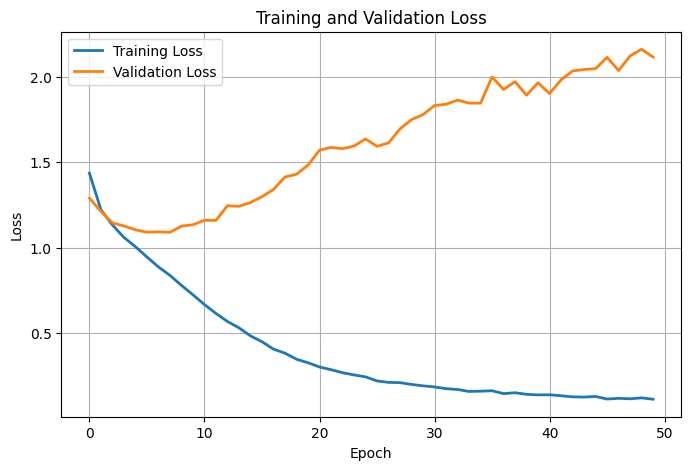

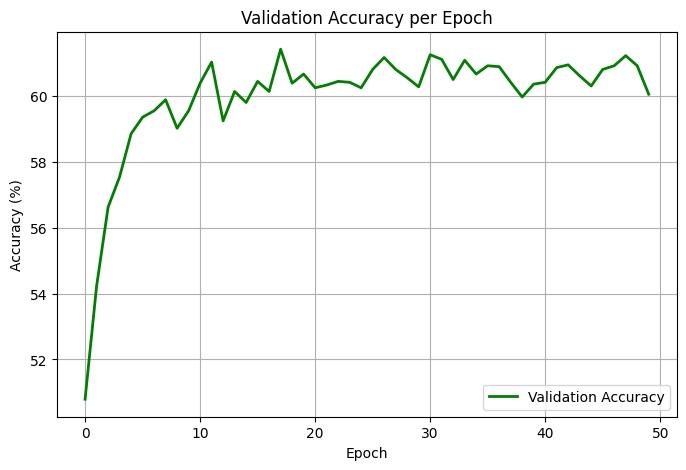

              precision    recall  f1-score   support

       Angry     0.4463    0.5696    0.5005       467
     Disgust     0.7647    0.4643    0.5778        56
        Fear     0.4640    0.4415    0.4525       496
       Happy     0.7973    0.7911    0.7942       895
         Sad     0.4992    0.4824    0.4907       653
    Surprise     0.7609    0.7590    0.7600       415
     Neutral     0.5523    0.5041    0.5271       607

    accuracy                         0.6004      3589
   macro avg     0.6121    0.5731    0.5861      3589
weighted avg     0.6052    0.6004    0.6010      3589



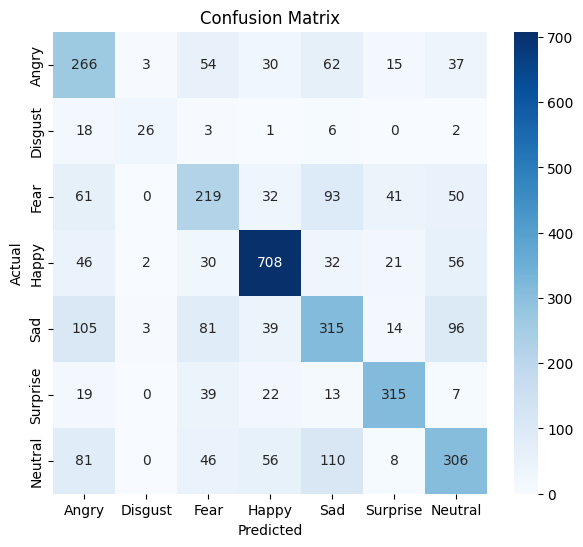

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ===============================
# 1️⃣  แสดงกราฟ Training & Validation Loss
# ===============================
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ===============================
# 2️⃣  แสดงกราฟ Accuracy ระหว่างการเทรน
# ===============================
plt.figure(figsize=(8,5))
plt.plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# ===============================
# 3️⃣  ประเมินผลลัพธ์สุดท้าย (Precision, Recall, F1-score)
# ===============================
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# แสดงผลการประเมินเชิงสถิติ
print(classification_report(all_labels, all_preds, target_names=EMOTIONS, digits=4))

# ===============================
# 4️⃣  แสดง Confusion Matrix
# ===============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
